In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/Магистратура/NLP_models")

In [3]:
import torch
import urllib.request
import datetime
import time
import os

In [4]:
def get_text8_data():
  url = 'http://mattmahoney.net/dc/text8.zip'
  if not os.path.exists('text8.zip'):
     urllib.request.urlretrieve(url, 'text8.zip')

  with open('text8.zip', 'rb') as f:
    from zipfile import ZipFile
    with ZipFile(f) as archive:
      data = archive.read('text8').decode('utf-8')
  return data

In [5]:
text8_data = get_text8_data().split()
statinfo = os.stat("./text8.zip")
# expected: 31344016
print(f"File size:{statinfo.st_size}")
print(f"{len(text8_data)=}")
print(f"{text8_data[:50]=}")

File size:31344016
len(text8_data)=17005207
text8_data[:50]=['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the']


In [6]:
UNK_TOKEN = "<UNK>"
UNK_IDX = 0
MIN_ACCURANCES = 10
word_to_idx: dict[str, int] = {UNK_TOKEN: UNK_IDX}

word_counts = {}

for word in text8_data:
  if word_counts.get(word, None) is None:
    word_counts[word] = 0
  word_counts[word] += 1

current_index = UNK_IDX + 1
for i in range(0, len(text8_data)):
  if word_counts[text8_data[i]] < MIN_ACCURANCES:
    # Replacing rare each word with UNK token
    text8_data[i] = UNK_TOKEN
  else:
    if text8_data[i] not in word_to_idx:
      word_to_idx[text8_data[i]] = current_index
      current_index += 1

idx_to_word = {v: k for k, v in word_to_idx.items()}

In [7]:
print(f"{len(word_counts)=}, {len(word_to_idx)=}, {len(text8_data)=}")

len(word_counts)=253854, len(word_to_idx)=47135, len(text8_data)=17005207


In [8]:
context_window = 3
embeddings_dim = 300

epochs = 3
learning_rate = 0.005
batch_size = 2048

In [9]:
# Generator of training data
from typing import Generator
import random

def get_batch(dataset: str, word_to_idx: dict[str, int], batch_size: int, context_window: int) -> Generator[tuple[list[int], list[list[int]]], None, None]:
  side_size = context_window // 2
  total_len = len(dataset)
  indexes = list(range(side_size, total_len - side_size))
  random.shuffle(indexes)

  words = []
  context_words = []
  for wi in indexes:
    words.append(word_to_idx[dataset[wi]])
    context_words.append([word_to_idx[dataset[ci]] for ci in list(range(wi - side_size, wi)) + list(range(wi + 1, wi + side_size + 1))])

    if len(words) == batch_size:
      yield words, context_words
      words = []
      context_words = []

for i, batch in enumerate(get_batch(dataset=text8_data, word_to_idx=word_to_idx, batch_size=2, context_window=context_window)):
    print(batch)
    if i == 5:
        break

([5224, 8943], [[6013, 6], [20, 4672]])
([1973, 40], [[3680, 6930], [1265, 180]])
([303, 266], [[302, 246], [88, 24879]])
([1329, 193], [[2231, 148], [123, 431]])
([268, 845], [[246, 301], [5222, 16]])
([9231, 9638], [[178, 6886], [3762, 21022]])


In [10]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA L4


In [11]:
# Thanks, Claude
def find_closest_embeddings(
    word: str,
    embedding_layer: torch.nn.Embedding,
    vocab_dict: dict[str, int],
    n_closest: int = 5
) -> list[tuple[str, float]]:
    """
    Find the closest word embeddings to a given word using cosine similarity.

    Args:
        word: The target word to find similar embeddings for
        embedding_layer: A PyTorch embedding layer
        vocab: List of words corresponding to the embedding indices
        n_closest: Number of closest words to return

    Returns:
        List of tuples containing (word, similarity_score)
    """
    # Get the word index
    try:
        word_idx = vocab_dict[word]
    except ValueError:
        raise ValueError(f"Word '{word}' not found in vocabulary")

    # Get the embedding for the target word
    word_embedding = embedding_layer.weight[word_idx]

    # Calculate cosine similarity between target word and all other embeddings
    similarities = torch.nn.functional.cosine_similarity(
        word_embedding.unsqueeze(0),
        embedding_layer.weight,
        dim=1
    )

    # Get the indices of the most similar words (excluding the target word)
    top_indices = torch.argsort(similarities, descending=True)[1:n_closest+1]

    # Create list of (word, similarity) pairs
    idx_to_word = {v: k for k, v in vocab_dict.items()}
    closest_words = [
        (idx_to_word[idx.item()], similarities[idx].item())
        for idx in top_indices
    ]

    return closest_words

In [12]:
# Model definition
class SkipGramLanguageModel(torch.nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(SkipGramLanguageModel, self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)
        self.vocab_size = vocab_size
        self.context_size = context_size


    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        logits = self.linear(embeds)
        return logits

In [13]:
# Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SkipGramLanguageModel(len(word_to_idx), embeddings_dim, context_window)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# Training
start_time = time.time()

for epoch in range(epochs):
  batch_num = 0
  for words, context_words in get_batch(dataset=text8_data, word_to_idx=word_to_idx, batch_size=batch_size, context_window=context_window):
    wordsT = torch.tensor(words).to(device)
    context_wordsT = torch.tensor(context_words).to(device)

    logits = model(wordsT)
    logits = logits.unsqueeze(1).expand(-1, model.context_size-1, -1)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), context_wordsT.flatten(0,1), ignore_index=0)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    optimizer.step()

    batch_num += 1

    if batch_num % 100 == 0:
      print(f"Epoch:{epoch}/{epochs}, batch {batch_num}/{len(text8_data) // batch_size}, loss: {loss.item()}")
    if batch_num % 1000 == 0:
      print(find_closest_embeddings("english", model.embeddings, word_to_idx))

print("--- Training time: %s seconds ---" % (time.time() - start_time))

model_name = f'skip_gram_{datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}'
torch.save(model.state_dict(), model_name)
print(f"{model_name=}")

Epoch:0/3, batch 100/8303, loss: 7.521566867828369
Epoch:0/3, batch 200/8303, loss: 7.198427677154541
Epoch:0/3, batch 300/8303, loss: 7.04738712310791
Epoch:0/3, batch 400/8303, loss: 7.1272077560424805
Epoch:0/3, batch 500/8303, loss: 7.032824993133545
Epoch:0/3, batch 600/8303, loss: 6.932905197143555
Epoch:0/3, batch 700/8303, loss: 6.811817646026611
Epoch:0/3, batch 800/8303, loss: 6.890711784362793
Epoch:0/3, batch 900/8303, loss: 6.862367630004883
Epoch:0/3, batch 1000/8303, loss: 6.907646656036377
[('irish', 0.24188362061977386), ('athena', 0.24020381271839142), ('cahiers', 0.23456014692783356), ('magic', 0.22892728447914124), ('ministerio', 0.227644145488739)]
Epoch:0/3, batch 1100/8303, loss: 6.84790563583374
Epoch:0/3, batch 1200/8303, loss: 6.878330230712891
Epoch:0/3, batch 1300/8303, loss: 6.729068279266357
Epoch:0/3, batch 1400/8303, loss: 6.761429786682129
Epoch:0/3, batch 1500/8303, loss: 6.746943950653076
Epoch:0/3, batch 1600/8303, loss: 6.720553874969482
Epoch:0/3, 

In [15]:
model.eval()

SkipGramLanguageModel(
  (embeddings): Embedding(47135, 300)
  (linear): Linear(in_features=300, out_features=47135, bias=True)
)

In [16]:
find_closest_embeddings("heart", model.embeddings, word_to_idx, n_closest=10)

[('liver', 0.40890049934387207),
 ('coronary', 0.3999730050563812),
 ('cardiac', 0.39279550313949585),
 ('kidney', 0.3753487765789032),
 ('ventricular', 0.3535841703414917),
 ('thyroid', 0.33496230840682983),
 ('gastrointestinal', 0.33308592438697815),
 ('lung', 0.32974934577941895),
 ('mind', 0.32944604754447937),
 ('stomach', 0.3287787437438965)]

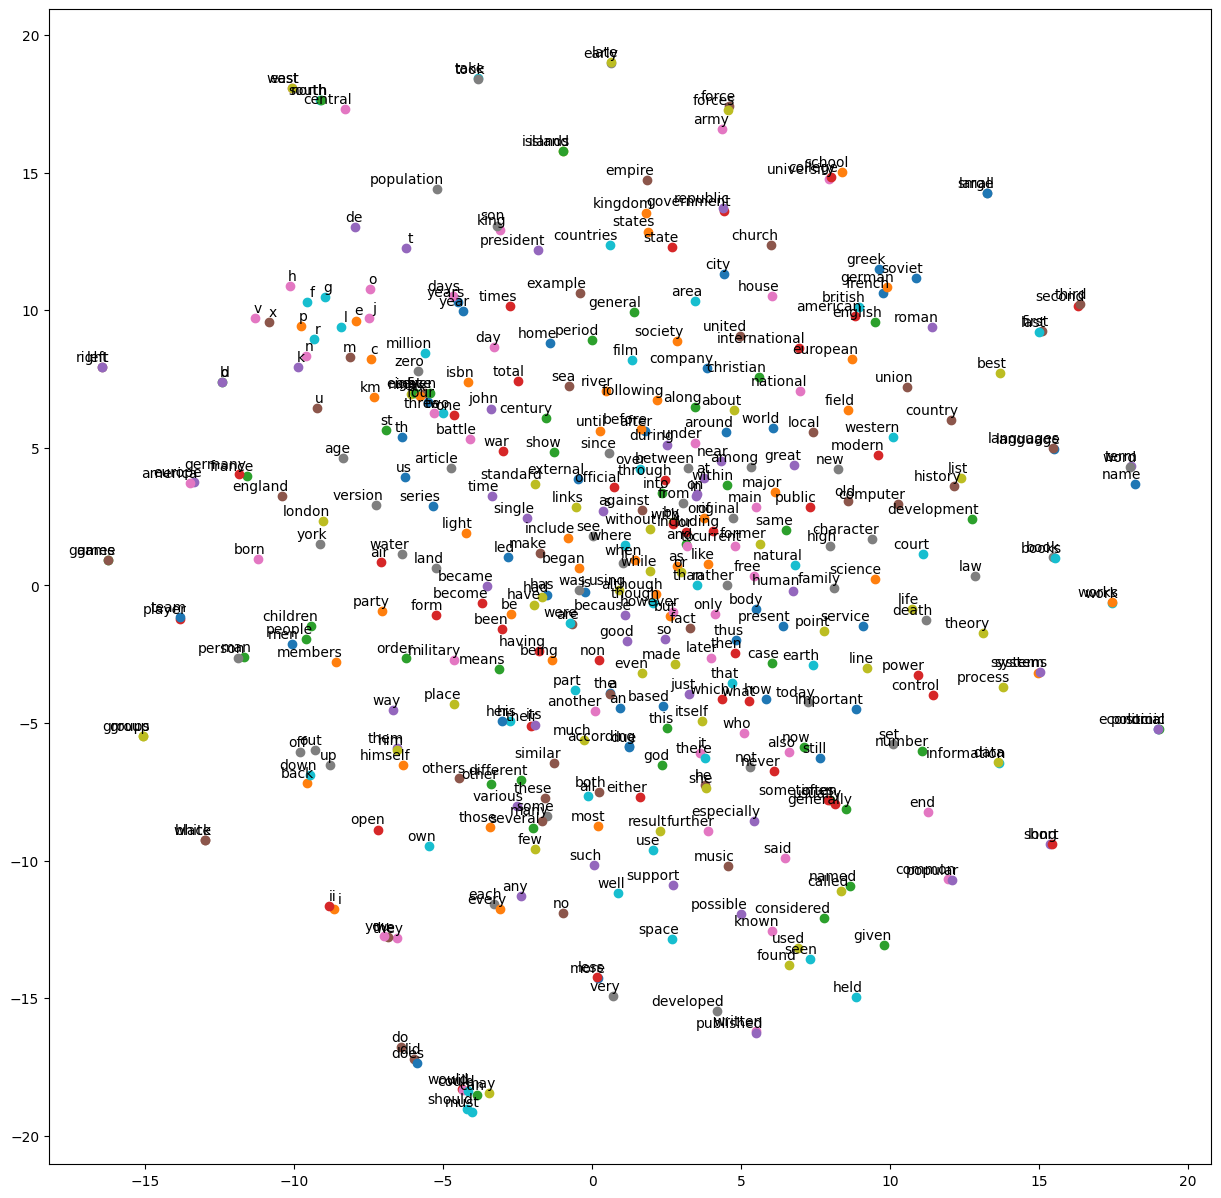

In [17]:
from sklearn.manifold import TSNE
from matplotlib import pylab

num_points = 400
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:num_points]

# Get the corresponding indices from word_to_idx for these words
words = []
indices = []
for word, count in top_words:
    words.append(word)
    indices.append(word_to_idx[word])

embeddings = model.embeddings(torch.tensor(indices).to(device)).cpu().squeeze(1).detach().numpy()

tsne = TSNE(perplexity=30, n_components=2, init='pca', max_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(embeddings)

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
  pylab.show()

plot(two_d_embeddings, words)